<img src="https://catalogo.uniandes.edu.co/-/media/Institution/Universidad-de-los-Andes/ingenieria/maestria-int-toma.ashx?la=es-ES">


# Universidad de los Andes - Modelos Avanzados para el Análisis de Datos

# Exercise 7 - Grupo 5

by [Daniela Carolina Sanabria, Jonny Eduardo Coronel, Oscar Mauricio Cepeda, Nestor Fabian Cholo]


## Part 1 - DT

### Capital Bikeshare data

## Introduction

- Capital Bikeshare dataset from Kaggle: [data](https://github.com/justmarkham/DAT8/blob/master/data/bikeshare.csv), [data dictionary](https://www.kaggle.com/c/bike-sharing-demand/data)
- Each observation represents the bikeshare rentals initiated during a given hour of a given day

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import matplotlib.pyplot as plt

In [2]:
# read the data and set "datetime" as the index
bikes = pd.read_csv('../datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

In [3]:
# "count" is a method, so it's best to rename that column
bikes.rename(columns={'count':'total'}, inplace=True)

In [4]:
# create "hour" as its own feature
bikes['hour'] = bikes.index.hour

In [5]:
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


In [6]:
bikes.tail()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,19
2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,20
2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,21
2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,22
2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88,23


In [7]:
bikes.shape

(10886, 12)

- **hour** ranges from 0 (midnight) through 23 (11pm)
- **workingday** is either 0 (weekend or holiday) or 1 (non-holiday weekday)

# Exercise 7.1

Run these two `groupby` statements and figure out what they tell you about the data.

La siguiente tabla muestra la media por hora de los alquileres de bicicletas para los días laborales (cuando Workingday toma el valor 1) y para los festivos o fines de semana (cuando Workingday es 0). En este caso, se evidencia que el número de bicicletas alquiladas promedio por hora es mayor en días laborales que en días festivos o fines de semana.

In [8]:
# mean rentals for each value of "workingday"

bikes.groupby('workingday').total.mean()

workingday
0    188.506621
1    193.011873
Name: total, dtype: float64

A su vez, la siguiente tabla discrimina la media de los alquileres por hora determinada del día. En este caso, se evidencia que entre 8 de la mañana y 7 de la noche hay un volumen mayor promedio de alquileres que a otras horas del día. En particular, la media alcanza su pico a las 5 y a las 6 de la tarde. 

In [9]:
# mean rentals for each value of "hour"

bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

# Exercise 7.2

Run this plotting code, and make sure you understand the output. Then, separate this plot into two separate plots conditioned on "workingday". (In other words, one plot should display the hourly trend for "workingday=0", and the other should display the hourly trend for "workingday=1".)

En línea con lo que mostraron los datos anteriores, la gráfica de abajo muestra un nivel promedio por hora de alquileres mayor durante el día, con picos de alquileres en las horas en las que usualmente empieza o termina el horario laboral de oficina (8:00 AM, 5:00 PM, y 6:00 PM).

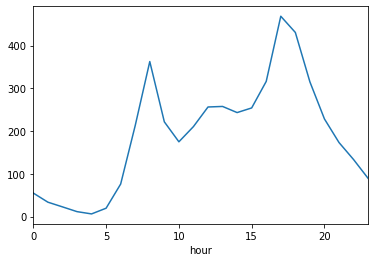

In [10]:
bikes.groupby('hour').total.mean().plot()

Plot for workingday == 0 and workingday == 1

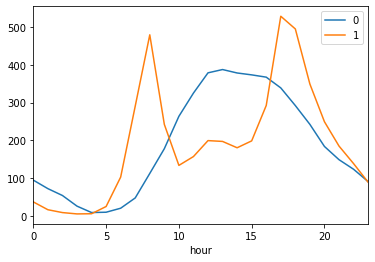

In [11]:
# combine the two plots
bikes.groupby(['hour', 'workingday']).total.mean().unstack().plot()
plt.legend()

Una discriminación de los datos según día laboral y fin de semana o festivo evidencia que la tendencia general refleja más el comportamiento de los días laborales. En días festivos y fines de semana, naturalmente, no hay picos en los horarios de entrada o salida en las oficinas, sino que los alquileres se comportan como una parábola que toma sus mayores valores entre 11 de la mañana y 5 de la tarde.

# Exercise 7.3

Fit a linear regression model to the entire dataset, using "total" as the response and "hour" and "workingday" as the only features. Then, print the coefficients and interpret them. What are the limitations of linear regression in this instance?

In [12]:
from sklearn.linear_model import LinearRegression

X=bikes[['hour', 'workingday']]
y=bikes['total']

reg = LinearRegression().fit(X, y)

In [13]:
print('Término independiente: \n', reg.intercept_)

Término independiente: 
 67.70595026191576


In [14]:
print('Coeficientes: \n', reg.coef_)

Coeficientes: 
 [10.49206282  4.07248627]


Los coeficientes de la regresión evidencian que manteniendo todo lo demás constante, cada hora del día más tarde en el día se relaciona en promedio con un aumento de 10.49 unidades en los alquileres por hora. En esta misma línea, el hecho de que el día de la medición sea un día de trabajo representa un aumento de 4.072 unidades en promedio en los alquileres por hora con respecto a los fines de semana y festivos. 

Sin embargo, la regresión lineal no es en este caso la mejor manera de predecir los alquileres, puesto que los alquileres no se comportan de manera líneal con respecto a las variables independientes consideradas (hour y working day), lo cual se puede constatar en el análisis gráfico anterior. Es por esto que el coeficiente de determinación R^2, resulta en un nivel muy bajo.

Los resultados completos de la regresión lineal se encuentran abajo.

In [15]:
print('R^2: \n', reg.score(X, y))

R^2: 
 0.16059115011434866


In [16]:
import statsmodels.api as sm

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


                            OLS Regression Results                            
Dep. Variable:                  total   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     1041.
Date:                Sun, 28 Jun 2020   Prob (F-statistic):               0.00
Time:                        15:18:12   Log-Likelihood:                -71093.
No. Observations:               10886   AIC:                         1.422e+05
Df Residuals:                   10883   BIC:                         1.422e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         67.7060      3.866     17.514      0.0

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


El MSE que se obtiene con todos los datos es el siguiente:

In [17]:
import sklearn.metrics
from sklearn.metrics import mean_squared_error

sklearn.metrics.mean_squared_error(y, reg.predict(X))

27541.255252498395

# Exercice 7.4

Create a Decision Tree to forecast "total" by manually iterating over the features "hour" and "workingday". The algorithm must at least have 6 end nodes.

Para predecir con un árbol de decisión, en primer lugar, separaremos nuestra muestra en entrenamiento y prueba.

In [18]:
from sklearn.model_selection import train_test_split

X=bikes[['hour', 'workingday']]
y=bikes['total']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

Como en este caso se trata de un problema de regresión, se creará una función que calcule la suma de los residuos al cuadrado, donde el valor de la preducción es la media de la variable. 

In [19]:
#Función para calcular la suma de residuos al cuadrado de la predicción

def ssr_(y):
    if y.shape[0] == 0:
        return 0
    else:
        return np.sum((y.mean()-y)**2)

En segundo lugar, se establecerá una función que recibiendo una variable característica, una variable depediente y un punto de separación para la primera, calcule la suma de los residuos al cuadrado definida para cada una de las particiones y las sume.

In [20]:
#Función para calcular los errores de una separación k para una determinada columna

def split_ssr(X_col, y, split):
    "Calculate the squared sum of residuals of an split k on feature j"
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    mean_y_l=y_l.mean()
    mean_y_r=y_r.mean()
     
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    ssr_y = ssr_(y)
    ssr_l = ssr_(y_l)
    ssr_r = ssr_(y_r)
    
    ssr_total=ssr_l+ssr_r
    
    return ssr_total

En tercer lugar, se calculará otra función que itere la anterior a través de varios puntos de separación (splits) de todas las columnas que tengan los datos y elija la separación con la menor suma de los residuos al cuadrado

In [21]:
def best_split(X, y, num_pct=10, min_samples_split=2):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, ssr_(y)]  # j, split, ssr
    
    # For all features
    for j in features:
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]

        # For all splits
        for split in splits:
            ssr = split_ssr(X.iloc[:, j], y, split)
            if ssr < best_split[2]:
                best_split = [j, split, ssr]
    return best_split

Por ejemplo, para nuestros datos completos, la mejor primer separación sería por la variable 0 (Hour), y el valor 8, con una suma de residuos al cuadrado en ambas separaciones de 257735770.92.

In [22]:
j, split, ssr = best_split(X, y, 5)
j, split, ssr

(0, 8.0, 257735770.92005637)

La siguiente función calculará un árbol de decisión usando las funciones anteriores. Se le añade el parámetro min_samples_split, que señala el número mínimo de observaciones necesarias para que de un nodo se pueda hacer una separación adicional. A su vez, se ajusta para que pare de hacer separaciones cuando dejen de haber mejoras en la suma de residuos al cuadrado. 

In [23]:
def tree_grow(X, y, level=0, max_depth=None, num_pct=10, min_samples_split=10):
    
    # If less than min_samples_split obs
    if y.shape[0] <= min_samples_split:
        tree = dict(y_pred=y.mean, level=level, split=-1, n_samples=y.shape[0], ssr=ssr_(y))
        return tree
    
    # Calculate the best split
    j, split, ssr = best_split(X, y, num_pct)

    # save tree and estimate prediction
    y_pred = y.mean()
    tree = dict(y_pred=y_pred, level=level, split=-1, n_samples=X.shape[0], ssr=ssr)

    # Check stooping criteria
    if ssr >= ssr_(y):
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   

    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Next iteration to each split
    tree['sl'] = tree_grow(X_l, y_l, level + 1, max_depth=max_depth, num_pct=num_pct, min_samples_split=min_samples_split)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, max_depth=max_depth, num_pct=num_pct, min_samples_split=min_samples_split)

    return tree


El árbol de regresión obtenido es el siguiente. Se evidencia que sin restringir el número de niveles del árbol se alcanzan 7. 

In [24]:
tree=tree_grow(X_train, y_train)
tree

{'y_pred': 191.37034120734907,
 'level': 0,
 'split': [0, 8.0],
 'n_samples': 7620,
 'ssr': 179207307.09609002,
 'sl': {'y_pred': 54.60392156862745,
  'level': 1,
  'split': [0, 7.0],
  'n_samples': 2550,
  'ssr': 10746665.107822917,
  'sl': {'y_pred': 32.54423592493298,
   'level': 2,
   'split': [0, 6.0],
   'n_samples': 2238,
   'ssr': 2645106.1664526854,
   'sl': {'y_pred': 24.950469238790408,
    'level': 3,
    'split': [0, 1.0],
    'n_samples': 1918,
    'ssr': 1349989.3596011202,
    'sl': {'y_pred': 53.599388379204896,
     'level': 4,
     'split': [1, 1.0],
     'n_samples': 327,
     'ssr': 337832.3491493886,
     'sl': {'y_pred': 92.58585858585859,
      'level': 5,
      'split': -1,
      'n_samples': 99,
      'ssr': 224598.0202020202},
     'sr': {'y_pred': 36.671052631578945,
      'level': 5,
      'split': -1,
      'n_samples': 228,
      'ssr': 113234.32894736841}},
    'sr': {'y_pred': 19.062225015713388,
     'level': 4,
     'split': [1, 1.0],
     'n_samples'

Por último, se crea una función para predecir con base en el árbol entrenado con la función anterior. La predicción corresponderá a la media de la variable en las hojas del árbol. 

In [25]:
def tree_predict(X, tree):
    
    predicted = np.ones(X.shape[0])

    # Check if final node
    if tree['split'] == -1:
            predicted = predicted * tree['y_pred']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # If left node is empty only continue with right
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])
        elif X_r.shape[0] == 0:  # If right node is empty only continue with left
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])

    return predicted    

Los resultados obtenidos de predicción con los datos de entrenamiento son los siguientes:

In [26]:
y_pred=tree_predict(X_test, tree)
y_pred

array([155.35714286,  20.55      , 296.28181818, ..., 287.22624434,
       108.10989011,   5.3952381 ])

En este caso, el MSE sería de 11882. Menos de la mitad del obtenido con la regresión lineal. 

In [27]:
import sklearn.metrics
from sklearn.metrics import mean_squared_error

sklearn.metrics.mean_squared_error(y_test, y_pred)

11882.791913819055

# Exercise 7.5

Train a Decision Tree using scikit-learn. Comment about the performance of the models.

En este caso calcularemos un árbol de regresión haciendo uso de cross validation para determinar el parámetro max_depth. 

In [28]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

# list of values to try for max_depth
max_depth_range = range(1, 10)

# list to store the average MSE for each value of max_depth
MSEs = []

# use 10-fold cross-validation with each value of max_depth

for depth in max_depth_range:
    clf = DecisionTreeRegressor(max_depth=depth, random_state=0)
    MSEs.append(cross_val_score(clf, X, y, cv=10, scoring='neg_mean_squared_error').mean())

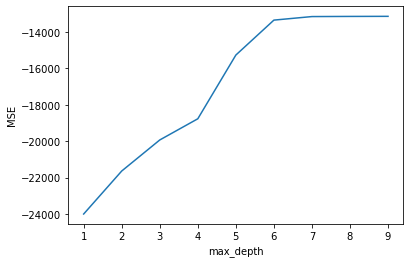

In [29]:
# plot max_depth (x-axis) versus RMSE (y-axis)
plt.plot(max_depth_range, MSEs)
plt.xlabel('max_depth')
plt.ylabel('MSE');

Se evidencia que la profundidad máxima es de 8, por lo cual se escogerá ese modelo. El MSE óptimo es de 13143, el cual, es superior al del árbol calculado a mano. 

In [30]:
MSEs[8]

-13143.878482047303

In [31]:
max(MSEs)

-13143.878482047303

Por lo tanto, se estimará el modelo con el mejor parámetro. En este caso, el MSE obtenido es muy cercano al obtenido en el anterior ejercicio. 

In [32]:
clf = DecisionTreeRegressor(max_depth=8, random_state=1)
clf_decisiontree=clf.fit(X_train, y_train)
sklearn.metrics.mean_squared_error(y_test, clf_decisiontree.predict(X_test))

11887.264708870263

# Part 2 - Bagging

## Mashable news stories analysis

Predicting if a news story is going to be popular

In [33]:
df = pd.read_csv('../datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [34]:
df['Popular'].value_counts()

1    3000
0    3000
Name: Popular, dtype: int64

In [35]:
df.shape

(6000, 61)

In [36]:
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']

In [37]:
y.mean()

0.5

In [38]:
y

0       1
1       0
2       0
3       0
4       0
       ..
5995    0
5996    1
5997    0
5998    0
5999    1
Name: Popular, Length: 6000, dtype: int64

In [39]:
# train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Exercise 7.6

Estimate a Decision Tree Classifier and a Logistic Regression

Evaluate using the following metrics:
* Accuracy
* F1-Score

In [40]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

clf = DecisionTreeClassifier(random_state=0)
Modelo1 = clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

print("accuracy: "+str(accuracy_score(y_test, y_pred))+" F1_score: "+str(f1_score(y_test, y_pred)))

accuracy: 0.5386666666666666 F1_score: 0.5417218543046358


In [41]:
from sklearn.linear_model import LogisticRegression
clf_log = LogisticRegression(random_state=0, solver='newton-cg')
Modelo2 = clf_log.fit(X_train, y_train)
y_pred2=clf_log.predict(X_test)

print("accuracy: "+str(accuracy_score(y_test, y_pred2))+" F1_score: "+str(f1_score(y_test, y_pred2)))


accuracy: 0.6466666666666666 F1_score: 0.6359890109890111


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


# Exercise 7.7

Estimate 300 bagged samples

Estimate the following set of classifiers:

* 100 Decision Trees where max_depth=None
* 100 Decision Trees where max_depth=2
* 100 Logistic Regressions

In [42]:
train=pd.concat([y_train, X_train], axis=1)
test=pd.concat([y_test, X_test], axis=1)
train

,Popular,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
2420,1,287.0,10.0,794.0,0.480720,1.0,0.712589,11.0,1.0,10.0,...,0.425597,0.062500,1.0,-0.227238,-0.5,-0.050000,0.000000,0.000000,0.500000,0.000000
1225,1,265.0,8.0,748.0,0.460114,1.0,0.582809,16.0,2.0,16.0,...,0.318308,0.083333,0.7,-0.473413,-0.7,-0.100000,0.400000,0.100000,0.100000,0.100000
324,0,375.0,12.0,2104.0,0.341929,1.0,0.508544,61.0,14.0,32.0,...,0.432095,0.033333,1.0,-0.236244,-0.8,-0.050000,0.454545,0.136364,0.045455,0.136364
5863,1,388.0,9.0,1281.0,0.461039,1.0,0.647832,36.0,33.0,14.0,...,0.452616,0.033333,1.0,-0.188155,-0.4,-0.050000,0.000000,0.000000,0.500000,0.000000
86,1,627.0,10.0,306.0,0.530612,1.0,0.601010,13.0,1.0,9.0,...,0.415417,0.100000,1.0,-0.292361,-0.6,-0.066667,0.357143,0.000000,0.142857,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,0,212.0,11.0,549.0,0.528545,1.0,0.667614,11.0,2.0,1.0,...,0.373900,0.062500,0.6,-0.356667,-0.6,-0.166667,0.800000,0.250000,0.300000,0.250000
5192,0,78.0,10.0,317.0,0.691489,1.0,0.793269,14.0,3.0,1.0,...,0.361364,0.200000,0.7,-0.278472,-0.4,-0.125000,0.500000,0.500000,0.000000,0.500000
3980,1,430.0,11.0,1105.0,0.413632,1.0,0.612903,8.0,4.0,1.0,...,0.359703,0.062500,1.0,-0.258218,-0.7,-0.025000,0.000000,0.000000,0.500000,0.000000
235,1,309.0,9.0,1129.0,0.455046,1.0,0.623894,20.0,1.0,11.0,...,0.466204,0.100000,1.0,-0.334791,-1.0,-0.071429,1.000000,0.850000,0.500000,0.850000


In [43]:
# set a seed for reproducibility
np.random.seed(123)

n_B = 100
n_samples = train.shape[0]

samples_1 = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
samples_1[0]

array([3582, 3454, 1346, ..., 2409, 3823,  992])

En primer lugar, calcularemos 100 árboles de decisión calculados con 100 muestras obtenidas por boostrap. En este caso el parámetro max_depth es None

In [44]:
clf = DecisionTreeClassifier(max_depth=None, random_state=123)

y_pred_dtc1 = pd.DataFrame(index=test.index, columns=[list(range(n_B))])
    
for i, sample in enumerate(samples_1):
    X_train = train.iloc[sample, 1:]
    y_train = train.iloc[sample, 0]
    clf.fit(X_train, y_train)
    y_pred_dtc1[[i]] = clf.predict(X_test)

In [45]:
y_pred_dtc1.head(2)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
1483,1,1,0,0,1,1,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2185,1,1,1,1,0,1,0,1,1,0,...,1,0,1,1,0,1,1,1,1,1


En segundo lugar, calcularemos otros 100 árboles de decisión, pero con parámetro max_depth 2. Estos serán estimados con otras 100 muestras obtenidas por boostrap.

In [46]:
# set a seed for reproducibility
np.random.seed(124)

n_B = 100
n_samples = train.shape[0]

samples_2 = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
samples_2[0]

array([ 135,  962,  681, ..., 1659, 3068,  720])

In [47]:
clf = DecisionTreeClassifier(max_depth=2, random_state=123)

y_pred_dtc2 = pd.DataFrame(index=test.index, columns=[list(range(n_B))])
    
for i, sample in enumerate(samples_2):
    X_train = train.iloc[sample, 1:]
    y_train = train.iloc[sample, 0]
    clf.fit(X_train, y_train)
    y_pred_dtc2[[i]] = clf.predict(X_test)

In [48]:
y_pred_dtc2.head(2)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
1483,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2185,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


En tercer lugar, calcularemos 100 regresiones logísticas. 

In [49]:
# set a seed for reproducibility
np.random.seed(125)

n_B = 100
n_samples = train.shape[0]

samples_3 = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]

samples_3[0]

array([3005, 2205, 3927, ...,  828, 1933, 2512])

In [50]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=123, max_iter=10000)

y_pred_logit = pd.DataFrame(index=test.index, columns=[list(range(n_B))])
    
for i, sample in enumerate(samples_3):
    X_train = train.iloc[sample, 1:]
    y_train = train.iloc[sample, 0]
    clf.fit(X_train, y_train)
    y_pred_logit[[i]] = clf.predict(X_test)

In [51]:
y_pred_logit.head(2)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
1483,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2185,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


# Exercise 7.8

Ensemble using majority voting

Evaluate using the following metrics:
* Accuracy
* F1-Score

In [52]:
y_pred_ensamb=pd.concat([y_pred_logit, y_pred_dtc2, y_pred_dtc1], axis=1)
y_pred_ensamb.shape

(1500, 300)

In [53]:
y_pred=round((y_pred_ensamb.sum(axis=1)/300))
y_pred

1483    1.0
2185    1.0
2520    1.0
3721    1.0
3727    0.0
       ... 
3077    0.0
5166    0.0
2227    1.0
5684    0.0
1937    0.0
Length: 1500, dtype: float64

In [54]:
from sklearn import metrics

print("accuracy: "+str(accuracy_score(y_test, y_pred))+" F1_score: "+str(f1_score(y_test, y_pred)))


accuracy: 0.6353333333333333 F1_score: 0.6235375086028905


# Exercise 7.9

Estimate te probability as %models that predict positive

Modify the probability threshold and select the one that maximizes the F1-Score

In [55]:
prob_pred=y_pred_ensamb.sum(axis=1)/300

In [56]:
prob_pred

1483    0.943333
2185    0.873333
2520    0.840000
3721    0.920000
3727    0.063333
          ...   
3077    0.413333
5166    0.130000
2227    0.853333
5684    0.146667
1937    0.110000
Length: 1500, dtype: float64

In [57]:
y_pred2=pd.DataFrame(index=prob_pred.index, columns=[np.arange(0.1, 1, 0.1)])

In [58]:
count=0
for threshold in list(np.arange(0.1, 1, 0.1)):
    for i in range(1500):
        if prob_pred.iloc[i] >=threshold:
            y_pred2.iloc[i, count]=1
        else:
            y_pred2.iloc[i, count]=0
    count=count+1
    

In [59]:
y_pred2

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
1483,1,1,1,1,1,1,1,1,1
2185,1,1,1,1,1,1,1,1,0
2520,1,1,1,1,1,1,1,1,0
3721,1,1,1,1,1,1,1,1,1
3727,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
3077,1,1,1,1,0,0,0,0,0
5166,1,0,0,0,0,0,0,0,0
2227,1,1,1,1,1,1,1,1,0
5684,1,0,0,0,0,0,0,0,0


In [60]:
from sklearn.metrics import f1_score

scores=list()

for i in range(9):
    a=f1_score(y_test, y_pred2.iloc[:,i])
    scores.append(a)


In [61]:
f1_score(y_test, y_pred2.iloc[:,0])

0.6968674698795181

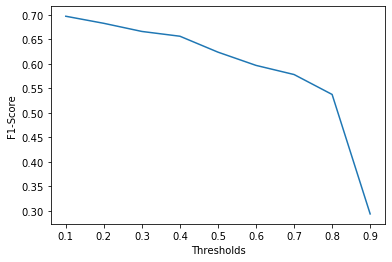

In [62]:
plt.plot(np.arange(0.1, 1, 0.1), scores)
plt.xlabel('Thresholds')
plt.ylabel('F1-Score');


Se evidencia que el threshold que maximiza el F1-Score es 0.1

In [63]:
scores

[0.6968674698795181,
 0.6824207492795388,
 0.6658506731946144,
 0.6560913705583756,
 0.6236263736263737,
 0.5966201322556944,
 0.5779816513761468,
 0.5373376623376623,
 0.2936763129689175]

# Exercise 7.10

Ensemble using weighted voting using the oob_error

Evaluate using the following metrics:
* Accuracy
* F1-Score

In [64]:
total_samples=np.concatenate((samples_1, samples_2, samples_3))
total_samples

array([[3582, 3454, 1346, ..., 2409, 3823,  992],
       [ 554, 1524, 1802, ..., 1314,  549, 1303],
       [3259,  595,  126, ...,  246, 2641,  580],
       ...,
       [ 232, 4122, 4082, ..., 3438, 2129, 3069],
       [ 909, 1470, 1056, ..., 3751, 2268, 4333],
       [2721,   15, 3019, ..., 3457, 3303, 3198]])

In [65]:
n_samples

4500

In [66]:
samples_oob = []
# show the "out-of-bag" observations for each sample
for sample in total_samples:
    samples_oob.append(sorted(set(range(n_samples)) - set(sample)))

In [67]:
n_estimators=300

trees_1 = {}
errors = np.zeros(n_estimators)

for i in range(n_estimators):
    if i<=100:
        trees_1[i]=DecisionTreeClassifier(max_depth=None, random_state=123)
        trees_1[i].fit(X_train.iloc[total_samples[i]], y_train.iloc[total_samples[i]])
        y_pred_1 = trees_1[i].predict(X_train.iloc[samples_oob[i]])
        errors[i] = 1 - metrics.accuracy_score(y_train.iloc[samples_oob[i]], y_pred_1)
    elif i<=200:
        trees_1[i]=DecisionTreeClassifier(max_depth=2, random_state=123)
        trees_1[i].fit(X_train.iloc[total_samples[i]], y_train.iloc[total_samples[i]])
        y_pred_1 = trees_1[i].predict(X_train.iloc[samples_oob[i]])
        errors[i] = 1 - metrics.accuracy_score(y_train.iloc[samples_oob[i]], y_pred_1)
    elif i<=300:
        trees_1[i]=LogisticRegression(random_state=123, max_iter=10000)
        trees_1[i].fit(X_train.iloc[total_samples[i]], y_train.iloc[total_samples[i]])
        y_pred_1 = trees_1[i].predict(X_train.iloc[samples_oob[i]])
        errors[i] = 1 - metrics.accuracy_score(y_train.iloc[samples_oob[i]], y_pred_1)

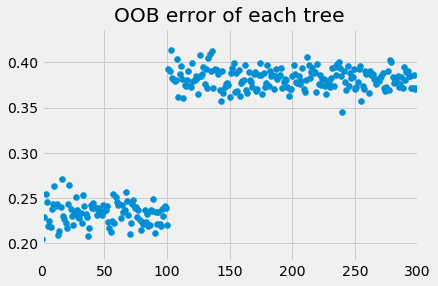

In [68]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.scatter(range(n_estimators), errors)
plt.xlim([0, n_estimators])
plt.title('OOB error of each tree');

In [69]:
alpha = (1 - errors) / (1 - errors).sum()

In [70]:
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df.iloc[:, i] = trees_1[i].predict(X_test)

In [71]:
weighted_sum_1 = ((y_pred_df) * alpha).sum(axis=1)

In [72]:
y_pred_2 = (weighted_sum_1 >= 0.5).astype(np.int)

metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred_2, y_test)

(0.6235375086028905, 0.6393333333333333)

# Exercise 7.11

Estimate te probability of the weighted voting

Modify the probability threshold and select the one that maximizes the F1-Score

In [73]:
weighted_sum_1

1483    0.961797
2185    0.908089
2520    0.812814
3721    0.885630
3727    0.061191
          ...   
3077    0.373935
5166    0.187687
2227    0.796987
5684    0.170983
1937    0.126021
Length: 1500, dtype: float64

In [74]:
y_pred_3=pd.DataFrame(index=weighted_sum_1.index, columns=[np.arange(0.1, 1, 0.1)])

count=0
for threshold in list(np.arange(0.1, 1, 0.1)):
    for i in range(1500):
        y_pred_3.iloc[i, count] = (weighted_sum_1.iloc[i]>= threshold).astype(np.int)
    count=count+1

In [75]:
from sklearn.metrics import f1_score

scores2=list()

for i in range(9):
    a=f1_score(y_test, y_pred_3.iloc[:,i])
    scores2.append(a)

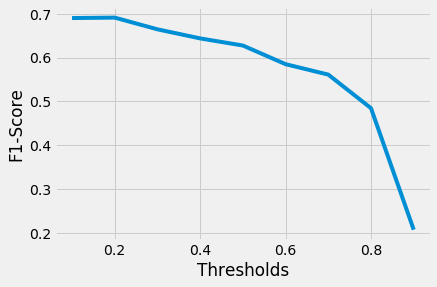

In [76]:
plt.plot(np.arange(0.1, 1, 0.1), scores2)
plt.xlabel('Thresholds')
plt.ylabel('F1-Score');

# Exercise 7.12

Estimate a logistic regression using as input the estimated classifiers

Modify the probability threshold such that maximizes the F1-Score

In [77]:
n_estimators=300

X_train_2 = pd.DataFrame(index=X_train.index, columns=list(range(n_estimators)))

for i in range(n_estimators):
    X_train_2[i] = trees_1[i].predict(X_train)
        

In [78]:
lr = LogisticRegression(random_state=123, max_iter=10000)
lr.fit(X_train_2, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [79]:
y_prob_final = lr.predict_proba(y_pred_df)

In [80]:
y_prob_final

array([[9.45218060e-05, 9.99905478e-01],
       [2.97507218e-03, 9.97024928e-01],
       [5.74988158e-01, 4.25011842e-01],
       ...,
       [6.91201804e-01, 3.08798196e-01],
       [7.36846401e-01, 2.63153599e-01],
       [9.73942030e-01, 2.60579696e-02]])

In [81]:
y_pred_4=pd.DataFrame(index=y_pred_df.index, columns=[np.arange(0.1, 1, 0.1)])

count=0
for threshold in list(np.arange(0.1, 1, 0.1)):
    for i in range(1500):
        y_pred_4.iloc[i, count] = (y_prob_final[i, 1]>= threshold).astype(np.int)
    count=count+1

In [82]:
from sklearn.metrics import f1_score

scores3=list()

for i in range(9):
    a=f1_score(y_test, y_pred_4.iloc[:,i])
    scores3.append(a)

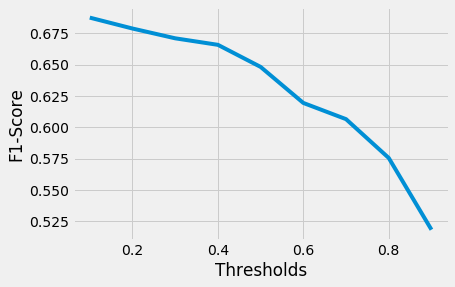

In [83]:
plt.plot(np.arange(0.1, 1, 0.1), scores3)
plt.xlabel('Thresholds')
plt.ylabel('F1-Score');

In [84]:
metrics.f1_score(y_pred_4.iloc[:,3], y_test), metrics.accuracy_score(y_pred_4.iloc[:,3], y_test)

(0.6658385093167701, 0.6413333333333333)